# " Sentiment Analysis on Amazon Alexa Reviews using NLP "

## Introduction
This project involves the analysis of Amazon Alexa customer reviews using 'Natural Language Processing' (NLP) and machine learning techniques. The dataset consists of nearly 3000 Amazon customer reviews for various Alexa products like Echo, Echo Dot, and Firestick.

## **Problem Statement**
Perform sentiment analysis on Amazon Alexa customer reviews to classify reviews as positive, negative, or neutral.

## Data Source
Used Kaggle Dataset [Amazon Alexa Reviews](https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews/data)

### Features:
<b>rating:</b> The star rating given by the customers.\
<b>date:</b> Date of the review.\
<b>variation:</b> Variant of the Alexa product.\
<b>verified_reviews:</b> Text of the customer review.\
<b>feedback:</b> Binary label (1 for positive, 0 for negative).

### 1. Data Loading and Exploration
Imported necessary libraries and Loaded the dataset and performed initial exploratory data analysis.
Visualized the distribution of ratings, feedback sentiments, product variations, and the number of reviews over time.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib import style
style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [4]:
# Load the dataset
df = pd.read_csv('amazon_alexa.tsv', sep='\t')
df.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [69]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

<b>Exploratory Data Analysis (EDA)
    
Conducted EDA by visualizing the data using libraries like Matplotlib, Seaborn and Plotly. Explored aspects like ratings distribution, variation distribution, and review length distribution.

<Axes: xlabel='rating', ylabel='count'>

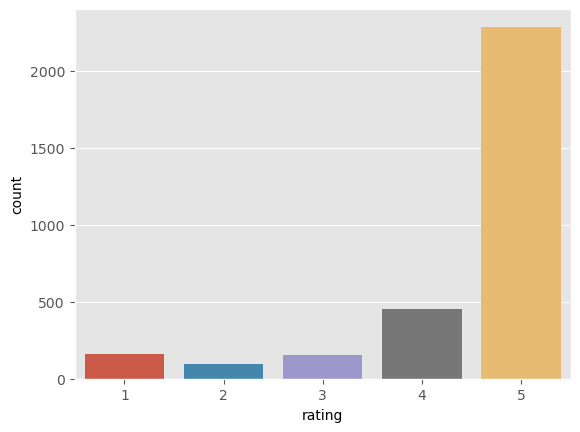

In [70]:
sns.countplot(x='rating', data=df)

In [71]:
df['rating'].value_counts()

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

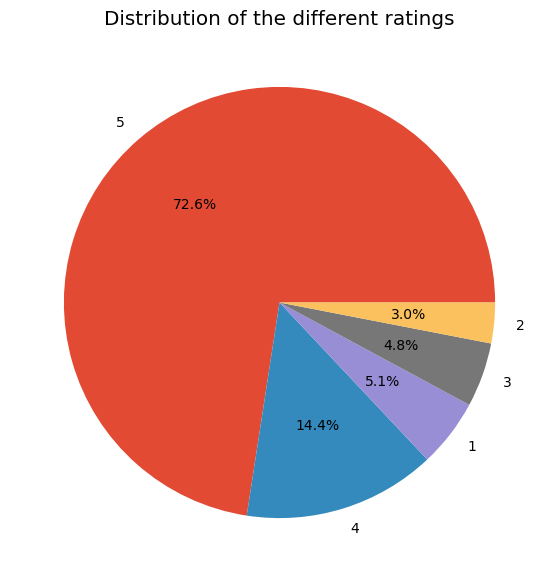

In [72]:
fig = plt.figure(figsize=(7,7))
tags = df['rating'].value_counts()
tags.plot(kind='pie', autopct='%1.1f%%', label='')
plt.title("Distribution of the different ratings")
plt.show()

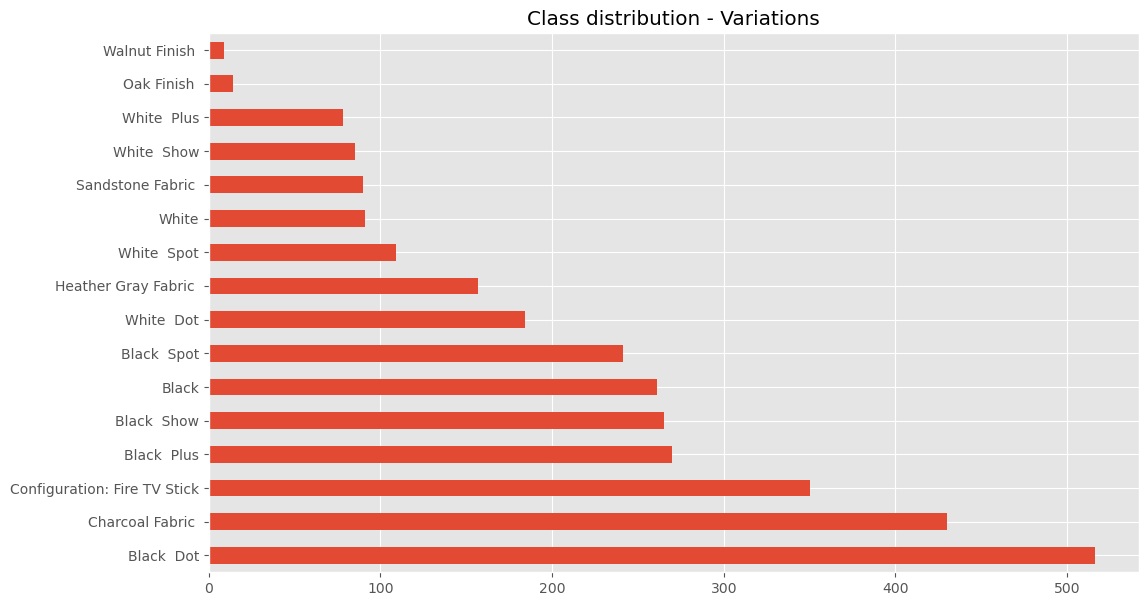

In [73]:
df.variation.value_counts().plot.barh(figsize=(12,7))
plt.title("Class distribution - Variations");

In [74]:
df['variation'].value_counts()

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

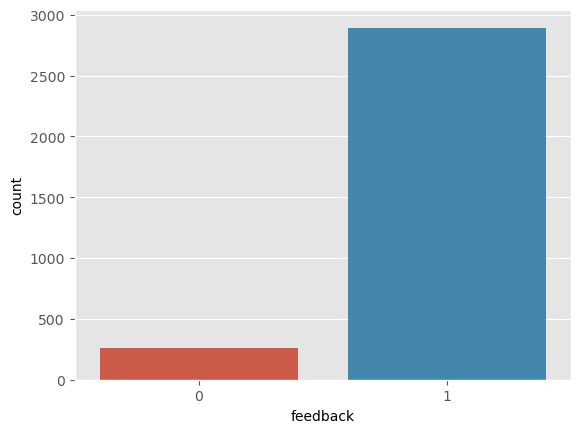

In [75]:
sns.countplot(x='feedback', data=df)
plt.show()

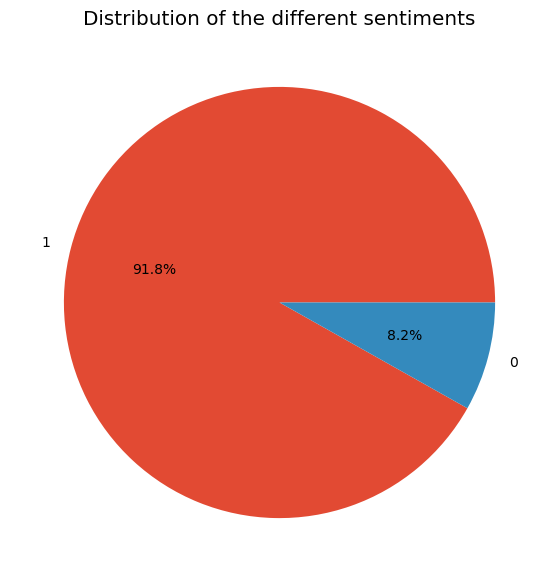

In [76]:
fig = plt.figure(figsize=(7,7))
tags = df['feedback'].value_counts()
tags.plot(kind='pie', autopct='%1.1f%%', label='')
plt.title("Distribution of the different sentiments")
plt.show()

In [77]:
df['review_length'] = df.verified_reviews.str.len()
df.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  review_length  
0                                      Love my Echo!         1             13  
1                                          Loved it!         1              9  
2  Sometimes while playing a game, you can answer...         1            195  
3  I have had a lot of fun with this thing. My 4 ...         1            172  
4                                              Music         1              5

In [78]:
df['review_length'].describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: review_length, dtype: float64

Text(0, 0.5, 'Count')

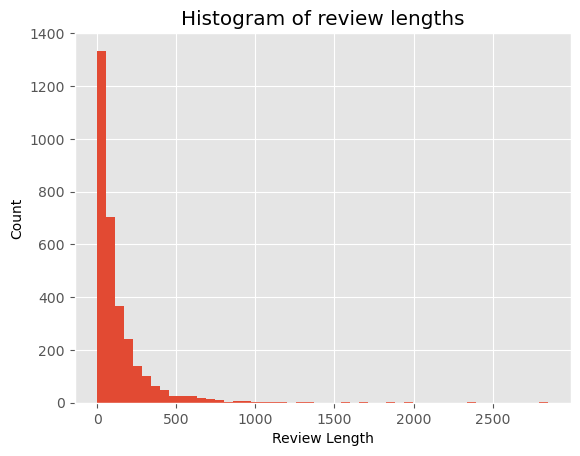

In [79]:
plt.hist(df['review_length'], bins=50)
plt.title("Histogram of review lengths")
plt.xlabel('Review Length')
plt.ylabel('Count')

In [80]:
import plotly.express as px

# Interactive histogram using Plotly
fig = px.histogram(df, x='review_length', color='feedback', marginal='box', nbins=100,
                   labels={'review_length': 'Review Length', 'feedback': 'Feedback'},
                   title='Interactive Histogram of Review Lengths')
fig.show()

In [82]:
# Assuming 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extracting year and month for analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Visualizing the number of reviews over time
time_based_plot = df.groupby(['year', 'month']).size().reset_index(name='count')
fig = px.line(time_based_plot, x='month', y='count', color='year',
              labels={'month': 'Month', 'count': 'Number of Reviews'},
              title='Monthly Reviews Over Time')
fig.show()

## 2. Data Preprocessing
Cleaned the text data by removing special characters and converting text to lowercase.
Tokenized the reviews and applied stemming and lemmatization techniques.
Explored the distribution of review lengths.

In [83]:
for i in range(5):
    print(df['verified_reviews'].iloc[i], "\n")
    print(df['feedback'].iloc[i], "\n")

Love my Echo! 

1 

Loved it! 

1 

Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. 

1 

I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. 

1 

Music 

1 



In [84]:
# Text Preprocessing

def data_processing(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+https\S+",'', text, flags = re.MULTILINE)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [85]:
df.verified_reviews = df['verified_reviews'].apply(data_processing)

In [86]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [87]:
df['verified_reviews'] = df['verified_reviews'].apply(lambda x:stemming(x))

In [88]:
for i in range(5):
    print(df['verified_reviews'].iloc[i], "\n")
    print(df['feedback'].iloc[i], "\n")

love echo 

1 

loved 

1 

sometimes playing game answer question correctly alexa says got wrong answers like able turn lights away home 

1 

lot fun thing 4 yr old learns dinosaurs control lights play games like categories nice sound playing music well 

1 

music 

1 



In [92]:
# Lemmatization function
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

# Applying lemmatization to verified_reviews column
df['verified_reviews'] = df['verified_reviews'].apply(lemmatize_text)

In [93]:
for i in range(5):
    print(df['verified_reviews'].iloc[i], "\n")
    print(df['feedback'].iloc[i], "\n")

love echo 

1 

loved 

1 

sometimes playing game answer question correctly alexa say got wrong answer like able turn light away home 

1 

lot fun thing 4 yr old learns dinosaur control light play game like category nice sound playing music well 

1 

music 

1 



In [94]:
pos_reviews = df[df.feedback==1]
pos_reviews.head()

rating       date         variation  \
0       5 2018-07-31  Charcoal Fabric    
1       5 2018-07-31  Charcoal Fabric    
2       4 2018-07-31    Walnut Finish    
3       5 2018-07-31  Charcoal Fabric    
4       5 2018-07-31  Charcoal Fabric    

                                    verified_reviews  feedback  review_length  \
0                                          love echo         1             13   
1                                              loved         1              9   
2  sometimes playing game answer question correct...         1            195   
3  lot fun thing 4 yr old learns dinosaur control...         1            172   
4                                              music         1              5   

   year  month  
0  2018      7  
1  2018      7  
2  2018      7  
3  2018      7  
4  2018      7

### Word Cloud Visualization
    
 Created word clouds for both positive and negative reviews.

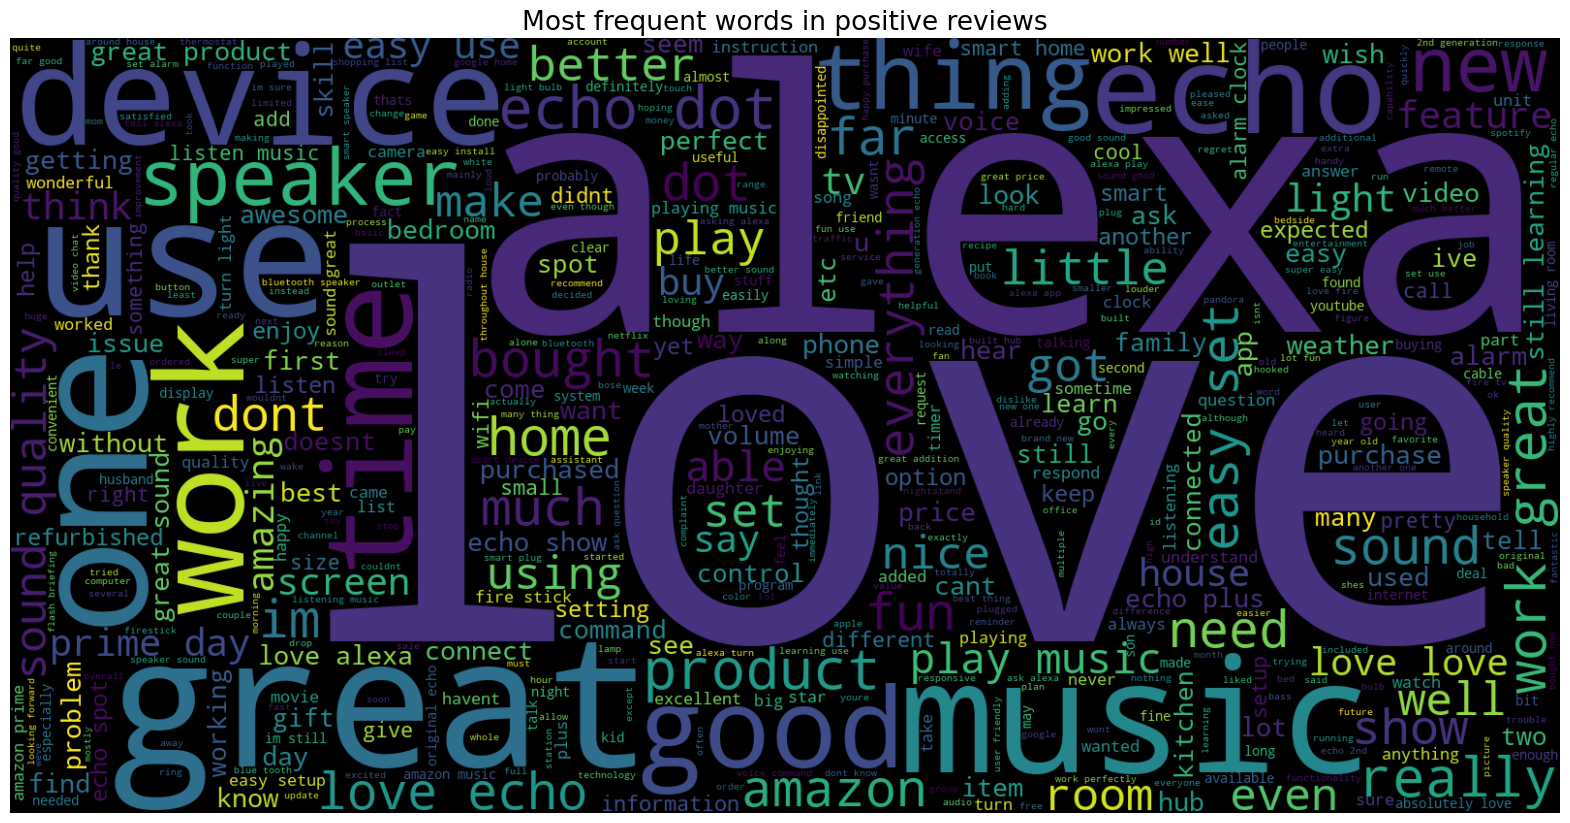

In [95]:
text = ' '.join([word for word in pos_reviews['verified_reviews']])
plt.figure(figsize=(20,15), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize=19)
plt.show()

In [96]:
neg_reviews = df[df.feedback==0]
neg_reviews.head()

rating       date             variation  \
46        2 2018-07-30      Charcoal Fabric    
111       2 2018-07-30      Charcoal Fabric    
141       1 2018-07-30      Charcoal Fabric    
162       1 2018-07-30     Sandstone Fabric    
176       2 2018-07-30  Heather Gray Fabric    

                                      verified_reviews  feedback  \
46   like siri fact siri answer accurately alexa do...         0   
111          sound terrible u want good music get bose         0   
141                                       much feature         0   
162  stopped working 2 week didnt follow command re...         0   
176                                 sad joke worthless         0   

     review_length  year  month  
46             163  2018      7  
111             53  2018      7  
141             18  2018      7  
162             87  2018      7  
176             20  2018      7

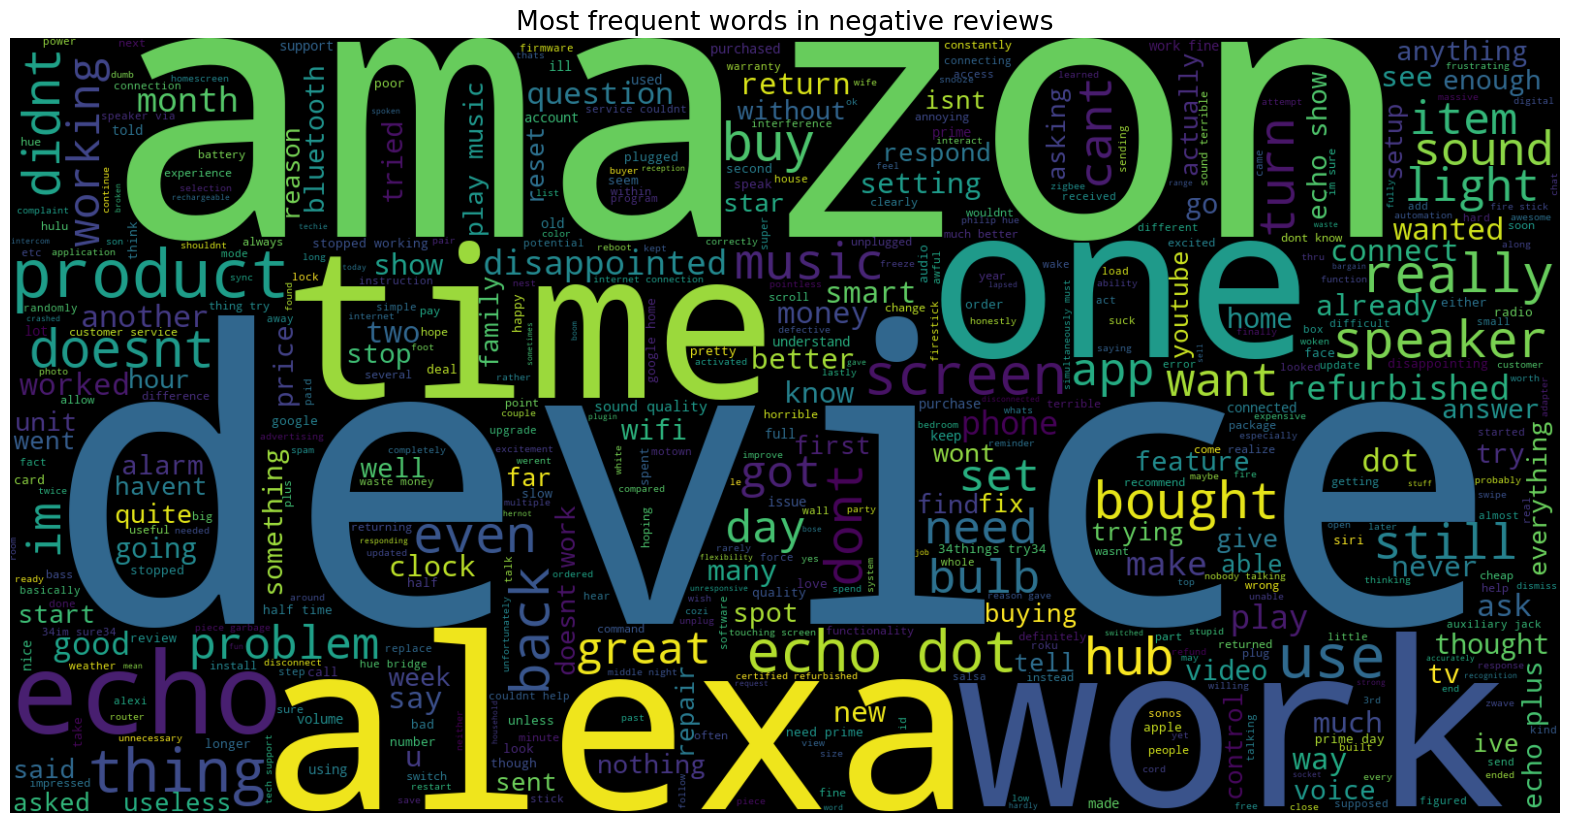

In [97]:
text = ' '.join([word for word in neg_reviews['verified_reviews']])
plt.figure(figsize=(20,15), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize=19)
plt.show()

In [ ]:
##################################################################

## 3. Sentiment Analysis and Model Evaluation
- Performed sentiment analysis using traditional machine learning models. Trained models like Logistic Regression or Naive Bayes using CountVectorizer-transformed data. Experimented with deep learning models (LSTM networks) for more complex analysis.

- Evaluated models using accuracy, confusion matrices, and classification reports. Analyzed misclassified examples to gain insights into model performance.

In [98]:
X = df['verified_reviews']
Y = df['feedback']

In [99]:
cv = CountVectorizer()
X = cv.fit_transform(df['verified_reviews'])

In [100]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [101]:
print("Size of x_train: ",(x_train.shape))
print("Size of y_train: ",(y_train.shape))
print("Size of x_test: ",(x_test.shape))
print("Size of y_test: ",(y_test.shape))

Size of x_train:  (2520, 3997)
Size of y_train:  (2520,)
Size of x_test:  (630, 3997)
Size of y_test:  (630,)


In [103]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 93.17%


In [104]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 18  40]
 [  3 569]]


              precision    recall  f1-score   support

           0       0.86      0.31      0.46        58
           1       0.93      0.99      0.96       572

    accuracy                           0.93       630
   macro avg       0.90      0.65      0.71       630
weighted avg       0.93      0.93      0.92       630



In [105]:
# Misclassified 
misclassified_indices = [i for i in range(len(y_test)) if logreg_pred[i] != y_test.iloc[i]]

# Print misclassified reviews
for index in misclassified_indices[:5]:  # Print first 5 misclassified reviews
    print("Review:", x_test[index])
    print("Predicted Sentiment:", logreg_pred[index])
    print("Actual Sentiment:", y_test.iloc[index])
    print("\n")

Review:   (0, 1227)	1
  (0, 1268)	2
  (0, 2006)	1
  (0, 3061)	1
  (0, 2549)	1
  (0, 3583)	1
  (0, 2750)	1
  (0, 623)	1
  (0, 3697)	1
Predicted Sentiment: 1
Actual Sentiment: 0


Review:   (0, 1178)	1
  (0, 2133)	1
  (0, 498)	1
  (0, 3953)	1
  (0, 2291)	1
  (0, 1131)	1
  (0, 2271)	1
  (0, 3950)	1
  (0, 3568)	1
  (0, 1497)	1
  (0, 2668)	1
Predicted Sentiment: 1
Actual Sentiment: 0


Review:   (0, 2777)	1
  (0, 254)	1
  (0, 3031)	1
  (0, 2072)	1
  (0, 275)	1
  (0, 1659)	1
  (0, 1043)	1
  (0, 1996)	1
  (0, 3953)	1
  (0, 1125)	1
  (0, 376)	1
  (0, 2039)	1
  (0, 1298)	1
Predicted Sentiment: 1
Actual Sentiment: 0


Review:   (0, 1178)	1
  (0, 2072)	1
  (0, 1944)	1
  (0, 1131)	1
  (0, 1285)	1
  (0, 3486)	1
  (0, 1405)	1
  (0, 3733)	1
  (0, 2954)	1
  (0, 358)	1
  (0, 84)	1
Predicted Sentiment: 1
Actual Sentiment: 0


Review:   (0, 3940)	1
  (0, 3766)	1
  (0, 3685)	1
Predicted Sentiment: 1
Actual Sentiment: 0




In [106]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_pred = mnb.predict(x_test)
mnb_acc = accuracy_score(mnb_pred, y_test)
print("Test accuracy: {:.2f}%".format(mnb_acc*100))

Test accuracy: 92.70%


In [107]:
print(confusion_matrix(y_test, mnb_pred))
print("\n")
print(classification_report(y_test, mnb_pred))

[[ 16  42]
 [  4 568]]


              precision    recall  f1-score   support

           0       0.80      0.28      0.41        58
           1       0.93      0.99      0.96       572

    accuracy                           0.93       630
   macro avg       0.87      0.63      0.69       630
weighted avg       0.92      0.93      0.91       630



In [45]:
#######################################################################3

In [49]:
# !pip install keras

     ---------------------------------------- 1.7/1.7 MB 6.8 MB/s eta 0:00:00


In [51]:
# !pip install tensorflow

     -------------------------------------- 284.1/284.1 MB 3.7 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 6.9 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 kB 7.5 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     -------------------------------------- 430.5/430.5 kB 6.7 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 6.7 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 5.3 MB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 kB 7.4 MB/s eta 0:00:00
     -------------------------------------- 182.0/182.0 kB 5.4 MB/s eta 0:00:00
     -------------------------------------- 15

In [109]:
# Deep Learning Model (LSTM)

tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(df['verified_reviews'])
X = tokenizer.texts_to_sequences(df['verified_reviews'])
X = pad_sequences(X)
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   0, 188],
       [  0,   0,   0, ...,  35, 256,  24],
       ...,
       [  0,   0,   0, ...,  11,  30, 223],
       [  0,   0,   0, ...,  60, 126,  14],
       [  0,   0,   0, ...,   0,   0,  17]])

In [110]:
X.shape

(3150, 159)

In [111]:
Y = df['feedback']

In [112]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [113]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (2520, 159)
Size of y_train:  (2520,)
Size of x_test:  (630, 159)
Size of y_test:  (630,)


In [114]:
model = Sequential()
model.add(Embedding(500, 120, input_length= X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 159, 120)          60000     
                                                                 
 spatial_dropout1d_1 (Spati  (None, 159, 120)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 64)                47360     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 107425 (419.63 KB)
Trainable params: 107425 (419.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [59]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
79/79 [==============================] - 17s 157ms/step - loss: 0.3238 - accuracy: 0.9147
Epoch 2/10
79/79 [==============================] - 16s 207ms/step - loss: 0.2315 - accuracy: 0.9222
Epoch 3/10
79/79 [==============================] - 19s 243ms/step - loss: 0.1640 - accuracy: 0.9353
Epoch 4/10
79/79 [==============================] - 19s 238ms/step - loss: 0.1242 - accuracy: 0.9536
Epoch 5/10
79/79 [==============================] - 22s 277ms/step - loss: 0.1075 - accuracy: 0.9579
Epoch 6/10
79/79 [==============================] - 24s 306ms/step - loss: 0.0891 - accuracy: 0.9687
Epoch 7/10
79/79 [==============================] - 24s 308ms/step - loss: 0.0896 - accuracy: 0.9663
Epoch 8/10
79/79 [==============================] - 24s 302ms/step - loss: 0.0708 - accuracy: 0.9746
Epoch 9/10
79/79 [==============================] - 22s 285ms/step - loss: 0.0629 - accuracy: 0.9770
Epoch 10/10
79/79 [==============================] - 22s 279ms/step - loss: 0.0588 - accura

In [60]:
Scores = model.evaluate(x_test, y_test)
print("Accuracy = %0.3f%%"%(Scores[1]*100))

20/20 [==============================] - 6s 112ms/step - loss: 0.2603 - accuracy: 0.9238
Accuracy = 92.381%


## 4. Visualization
Plotted loss and accuracy curves for LSTM models.

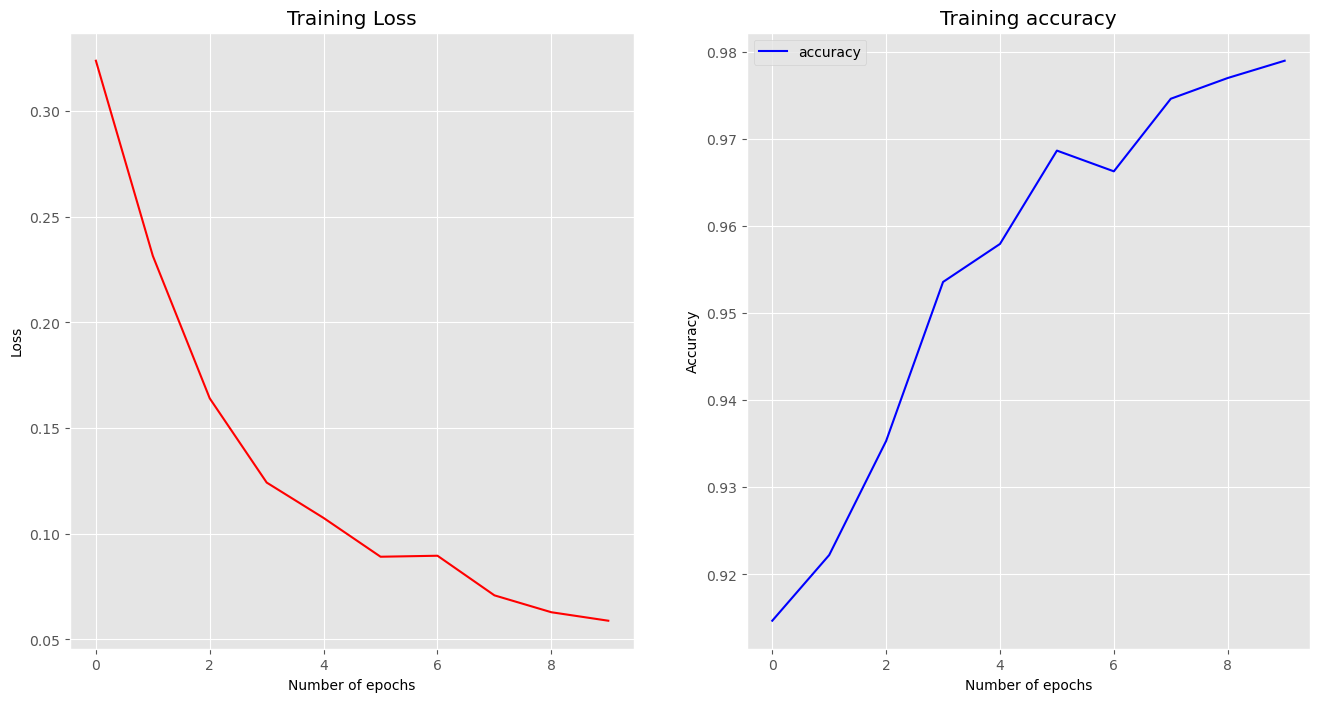

In [61]:
# Visualize training history

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r', label='loss')
plt.title('Training Loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='b', label='accuracy')
plt.title('Training accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [62]:
model = Sequential()
model.add(Embedding(500, 120, input_length= X.shape[1]))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 145, 120)          60000     
                                                                 
 lstm_1 (LSTM)               (None, 32)                19584     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 79617 (311.00 KB)
Trainable params: 79617 (311.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [63]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
79/79 [==============================] - 15s 140ms/step - loss: 0.3333 - accuracy: 0.9183
Epoch 2/10
79/79 [==============================] - 11s 138ms/step - loss: 0.2321 - accuracy: 0.9222
Epoch 3/10
79/79 [==============================] - 26s 326ms/step - loss: 0.1602 - accuracy: 0.9341
Epoch 4/10
79/79 [==============================] - 18s 225ms/step - loss: 0.1230 - accuracy: 0.9567
Epoch 5/10
79/79 [==============================] - 14s 182ms/step - loss: 0.0986 - accuracy: 0.9647
Epoch 6/10
79/79 [==============================] - 16s 209ms/step - loss: 0.0821 - accuracy: 0.9710
Epoch 7/10
79/79 [==============================] - 20s 254ms/step - loss: 0.0683 - accuracy: 0.9754
Epoch 8/10
79/79 [==============================] - 21s 267ms/step - loss: 0.0626 - accuracy: 0.9802
Epoch 9/10
79/79 [==============================] - 18s 223ms/step - loss: 0.0553 - accuracy: 0.9802
Epoch 10/10
79/79 [==============================] - 22s 283ms/step - loss: 0.0481 - accura

In [64]:
Scores = model.evaluate(x_test, y_test)
print("Accuracy = %0.3f%%"%(Scores[1]*100))

20/20 [==============================] - 2s 39ms/step - loss: 0.2410 - accuracy: 0.9317
Accuracy = 93.175%


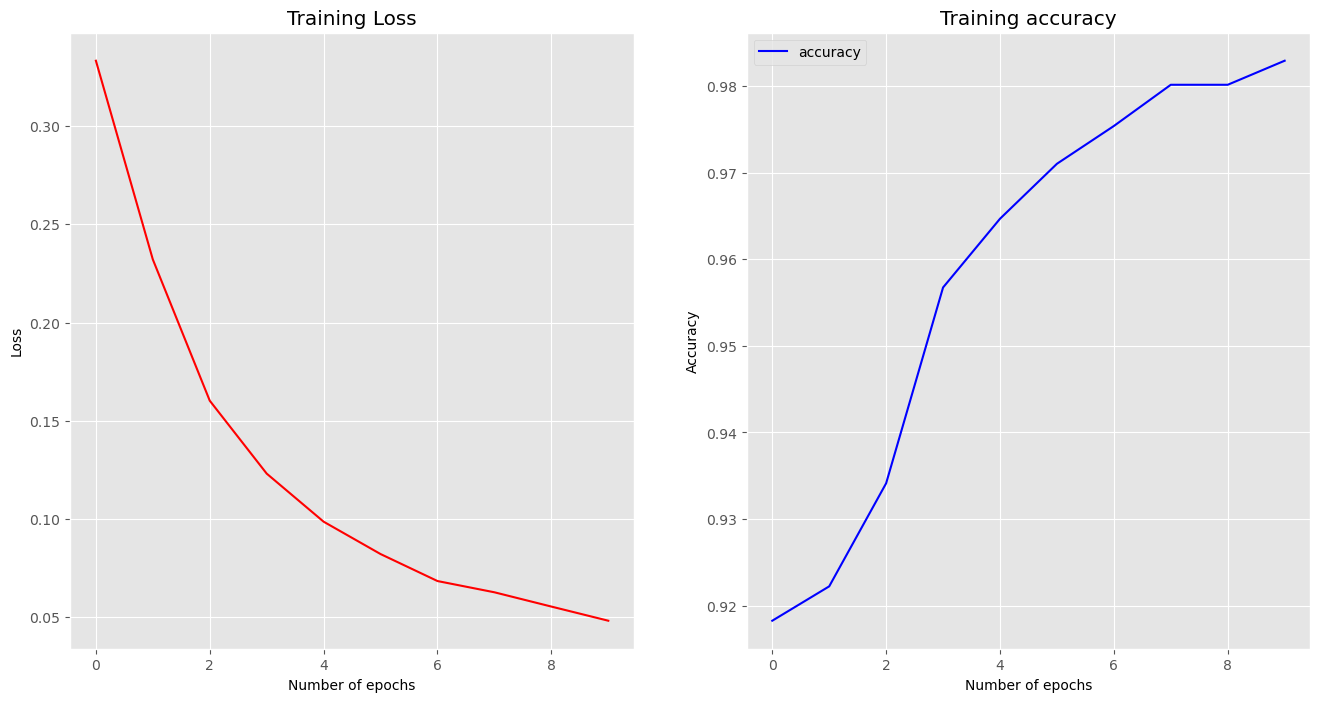

In [65]:
# Visualize training history

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r', label='loss')
plt.title('Training Loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='b', label='accuracy')
plt.title('Training accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [115]:
# Example: Trying different LSTM architectures and hyperparameters

model = Sequential()
model.add(Embedding(500, 120, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))  # Experiment with dropout rates
model.add(LSTM(128, return_sequences=True))  # Experiment with LSTM units
model.add(LSTM(64))  # Experiment with LSTM units
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with new architecture
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
79/79 [==============================] - 73s 844ms/step - loss: 0.3067 - accuracy: 0.9131 - val_loss: 0.3069 - val_accuracy: 0.9079
Epoch 2/10
79/79 [==============================] - 60s 756ms/step - loss: 0.2761 - accuracy: 0.9210 - val_loss: 0.3181 - val_accuracy: 0.9079
Epoch 3/10
79/79 [==============================] - 62s 793ms/step - loss: 0.2377 - accuracy: 0.9242 - val_loss: 0.2202 - val_accuracy: 0.9111
Epoch 4/10
79/79 [==============================] - 63s 794ms/step - loss: 0.1570 - accuracy: 0.9460 - val_loss: 0.2178 - val_accuracy: 0.8968
Epoch 5/10
79/79 [==============================] - 79s 999ms/step - loss: 0.1165 - accuracy: 0.9567 - val_loss: 0.2595 - val_accuracy: 0.9127
Epoch 6/10
79/79 [==============================] - 87s 1s/step - loss: 0.1001 - accuracy: 0.9639 - val_loss: 0.2361 - val_accuracy: 0.9048
Epoch 7/10
79/79 [==============================] - 89s 1s/step - loss: 0.0850 - accuracy: 0.9690 - val_loss: 0.2440 - val_accuracy: 0.9159
Epoch

# Results:
Traditional machine learning models (Logistic Regression, Naive Bayes) achieved decent accuracy for sentiment classification.
Deep learning models (LSTM networks) performed competitively, demonstrating the ability to handle complex NLP tasks.
# Conclusion:
The project successfully analyzed customer sentiment in Amazon Alexa reviews.
Demonstrated proficiency in data preprocessing, exploratory data analysis, and various machine learning techniques.
Explored both traditional and advanced methods, showcasing versatility in solving NLP problems.

## Next Steps/ Future Work:
Experiment with more advanced NLP techniques, such as transformer-based models like BERT, for nuanced sentiment analysis.
Explore other NLP tasks like aspect-based sentiment analysis and topic modeling for a deeper understanding of customer feedback.